# EU Transaction Log Database

<br>

### Imports

In [571]:
import pandas as pd
import numpy as np
import xarray as xr

import re
import os
import copy
import requests
from bs4 import BeautifulSoup as bs

import matplotlib.pyplot as plt

from ipypb import track
import FEAutils as hlp

In [2]:
from IPython.display import JSON

<br>

### Identifying Operator Holding Accounts

We'll start by calling the first page of the unfiltered search

In [150]:
#exports
get_accounts_raw_search = lambda page_num=0: requests.get(f'https://ec.europa.eu/clima/ets/oha.do?form=oha&languageCode=en&accountHolder=&installationIdentifier=&installationName=&permitIdentifier=&mainActivityType=-1&searchType=oha&currentSortSettings=&backList=%3CBack&resultList.currentPageNumber={page_num}')

In [151]:
r = get_accounts_raw_search()

r

<Response [200]>

In [152]:
#exports
def extract_search_df(r):
    soup = bs(r.text)
    results_table = soup.find('table', attrs={'id': 'tblAccountSearchResult'})

    df_search = (pd
                 .read_html(str(results_table))
                 [0]
                 .iloc[1:, :-2]
                 .reset_index(drop=True)
                 .T
                 .set_index(0)
                 .T
                 .reset_index(drop=True)
                 .rename(columns={
                     'National Administrator': 'country',
                     'Account Type': 'account_type',
                     'Account Holder Name': 'account_holder_name',
                     'Installation/Aircraft ID': 'installation_or_aircraft_id',
                     'Installation Name/Aircraft Operator Code*': 'operator_code',
                     'Company Registration No': 'company_registration_number',
                     'Permit/Plan ID': 'permit_or_plan_id',
                     'Permit/Plan Date': 'permit_or_plan_date',
                     'Main Activity Type': 'main_activity_type',
                     'Latest Compliance Code': 'latest_compliance_code'
                 })
                )
    
    df_search['account_id'] = [a['href'].split('accountID=')[-1].split('&')[0] for a in results_table.findAll('a', text=re.compile('Details - All Phases'))]

    return df_search

In [153]:
df_search = extract_search_df(r)

df_search.head(3)

,country,account_type,account_holder_name,installation_or_aircraft_id,operator_code,company_registration_number,permit_or_plan_id,permit_or_plan_date,main_activity_type,latest_compliance_code,account_id
0,Austria,Aircraft Operator Account,Jetalliance Flugbetriebs GmbH,200103,27702,FN 203001g,BMLFUW-UW.1.3.2/0354-V/4/2009,2010-01-01,Aircraft operator activities,C,90574
1,Austria,Aircraft Operator Account,Glock GmbH,200108,194,FN64142b,BMFLUW-UW.1.3.2/0084-V/4/2010,2010-01-01,Aircraft operator activities,A,90727
2,Austria,Aircraft Operator Account,Glock Services GmbH,200109,36057,FN329154a,UW.1.3.2/0085-V/4/2011,2010-01-01,Aircraft operator activities,A,90728


In [154]:
#exports
def get_num_operating_accounts_pages():
    r = get_accounts_raw_search()
    soup = bs(r.text)
    
    soup_pn = soup.find('input', attrs={'name': 'resultList.lastPageNumber'})
    num_pages = int(soup_pn['value'])
    
    return num_pages

In [453]:
num_pages = get_num_operating_accounts_pages()

num_pages

883

In [ ]:
#exports
def get_full_search_df(num_pages):
    df_search = pd.DataFrame()

    for page_num in track(range(num_pages)):
        r = get_accounts_raw_search(page_num=page_num)
        df_search_page = extract_search_df(r)
        df_search = df_search.append(df_search_page)

    df_search = (df_search
                 .reset_index(drop=True)
                 .drop_duplicates()
                )
    
    return df_search

def get_search_df(data_dir='data', num_pages=None, redownload=False):
    if num_pages is None:
        num_pages = get_num_operating_accounts_pages()
        
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    if redownload == True:
        df_search = get_full_search_df(num_pages)
        df_search.to_csv(f'{data_dir}/account_search.csv', index=False)
    else:
        df_search = pd.read_csv(f'{data_dir}/account_search.csv')

In [456]:
redownload_search_df = False

df_search = get_search_df(data_dir='../data', redownload=redownload_search_df)

df_search.shape

 [████████████████████████████████████████████████████████████] 883/883 [09:19<00:01, 0.63s/it]

(17620, 11)

<br>

We would intuitively expect to see only unique values in the `permit_or_plan_id` column but we can see for values such as `EEW012` that this is not the case. In this instance it appears as though the account holder name has changed, meaning that the emissions data has been split despite it being owned by the same overarching company - these are problems we will have to address later.

In [174]:
df_search.loc[df_search['permit_or_plan_id']=='EEW012']

,country,account_type,account_holder_name,installation_or_aircraft_id,operator_code,company_registration_number,permit_or_plan_id,permit_or_plan_date,main_activity_type,latest_compliance_code,account_id
137,Austria,Operator Holding Account,VERBUND Thermal Power GmbH & Co KG,97,Verbund KW Voitsberg,FN 220426 g,EEW012,2004-01-02,Combustion installations with a rated thermal ...,C,93794
271,Austria,Operator Holding Account,A-Tec Beteiligungs GmbH,233,DKW Voitsberg,FN 294601 m,EEW012,2005-06-09,Combustion installations with a rated thermal ...,A,93944


In [458]:
df_search['account_type'].value_counts()

Operator Holding Account     16040
Aircraft Operator Account     1580
Name: account_type, dtype: int64

<br>

### Retrieving Installation/Operator Data

In this section we'll start looking at individual operator accounts and extracting some more detailed information 

In [55]:
#exports
account_id_to_url = lambda account_id: f'https://ec.europa.eu/clima/ets/ohaDetails.do?accountID={account_id}&action=all'

In [427]:
account_id = df_search.loc[df_search['account_type']=='Aircraft Operator Account', 'account_id'].iloc[0]
account_url = account_id_to_url(account_id)

account_url

'https://ec.europa.eu/clima/ets/ohaDetails.do?accountID=90574&action=all'

<br>

We'll create a function that extracts the relevant tables as Beautiful Soup objects

In [496]:
#exports
def retry_request(root_url, params={}, n_retries=5, **kwargs):
    for i in range(n_retries):
        try:
            r = requests.get(root_url, params=params, **kwargs)
            return r
        except Exception as e:
            continue

    raise e
    
def extract_key_table_soups(account_url):
    r = retry_request(account_url)
    soup = bs(r.text)

    operator_master_table = soup.find('table', attrs={'summary': 'Master account details'})
    operator_child_table, compliance_table = soup.findAll('table', attrs={'summary': 'Child account details'})
    
    return operator_master_table, operator_child_table, compliance_table

In [299]:
operator_master_table, operator_child_table, compliance_table = extract_key_table_soups(account_url)

len(operator_master_table), len(operator_child_table), len(compliance_table)

(5, 5, 3)

<br>

The first table we'll extract is the time-series compliance data

In [257]:
def try_convert(value, default, type_):
    try:
        return type_(value)
    except:
        pass
            
    return default

filter_for_year_indexes = lambda df: df.loc[pd.Series(df.index).apply(try_convert, args=(np.nan, float)).dropna().astype(int).astype(str).values]

def extract_compliance_df(compliance_table):
    df_compliance = (pd
                     .read_html(str(compliance_table))[1].iloc[1:, :-2]
                     .reset_index(drop=True)
                     .T
                     .set_index(0)
                     .T
                     .reset_index(drop=True)
                     .drop(columns=['EU ETS Phase', 'Cumulative Surrendered Units**', 'Cumulative Verified Emissions***'])
                     .set_index('Year')
                     .pipe(filter_for_year_indexes)
                     .rename(columns={
                         'Allowances in Allocation': 'allocated_allowances',
                         'Verified Emissions': 'verified_emissions',
                         'Units Surrendered': 'units_surrendered',
                         'Compliance Code': 'compliance_code'
                     })
                    )

    return df_compliance

In [258]:
df_compliance = extract_compliance_df(compliance_table)

df_compliance.head()

,allocated_allowances,verified_emissions,units_surrendered,compliance_code
Year,,,,
2005,8492,12104,12104,A
2006,8492,12256,12256,A
2007,8492,14976,14976,A
2008,14063,17523,17523,A*
2009,17155,16815,16815,A


<br>

We'll quickly visualise the cumulative excess emissions for the account we've just retrieved.

When the cumulative emissions are below 0 we can imagine the account as being in credit, whereas when its above 0 we can view it as being in debt.

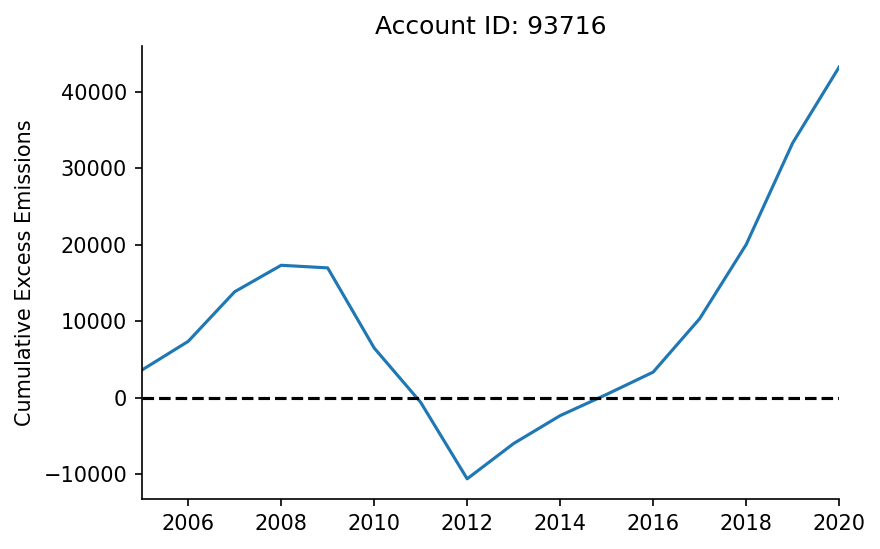

In [297]:
df_plot = df_compliance[['allocated_allowances', 'verified_emissions']].astype(float).astype('Int64').dropna(how='all')
df_plot.index = df_plot.index.astype(int)

# Plotting
fig, ax = plt.subplots(dpi=150)

(df_plot['verified_emissions']-df_plot['allocated_allowances']).cumsum().plot(ax=ax)
ax.plot([df_plot.index.min(), df_plot.index.max()], [0, 0], 'k--')

ax.set_title(f'Account ID: {account_id}')
ax.set_ylabel('Cumulative Excess Emissions')
ax.set_xlabel('')
ax.set_xlim(df_plot.index.min(), df_plot.index.max())
hlp.hide_spines(ax)

<br>

We'll take a quick look at how well the tables can be parsed into dataframes using `pd.read_html` alone

In [390]:
_ , df_master_general_info, _, df_contact_info = pd.read_html(str(operator_master_table))
_ , df_child_general_info, df_address_info = pd.read_html(str(operator_child_table))

df_master_general_info

,0,1,2,3,4,5,6
0,General Information,General Information,General Information,General Information,General Information,General Information,General Information
1,National Administrator,Account Type,Account Holder Name,Installation ID,Company Registration No,Account Status,NaN
2,Austria,100-Holding Account,Breitenfeld Edelstahl AG,2,FN 74471 t,open,NaN


<br>

We'll create some helper functions for extracting data from the different tables individually

In [442]:
#exports
extract_single_row_table_info = lambda df_info, num_excess_start_cols, last_end_col: df_info.iloc[num_excess_start_cols:, :last_end_col].reset_index(drop=True).T.set_index(0)[1].to_dict()

extract_master_general_info = lambda df_master_general_info: extract_single_row_table_info(df_master_general_info, 1, 6)
extract_child_general_info = lambda df_child_general_info: extract_single_row_table_info(df_child_general_info, 1, 10)
extract_contact_info = lambda df_contact_info: extract_single_row_table_info(df_contact_info, 1, 11)
extract_address_info = lambda df_address_info: extract_single_row_table_info(df_address_info, 1, 8)

In [393]:
extract_aircraft_master_general_info(df_master_general_info)

{'National Administrator': 'Austria',
 'Account Type': '100-Holding Account',
 'Account Holder Name': 'Breitenfeld Edelstahl AG',
 'Installation ID': '2',
 'Company Registration No': 'FN 74471 t',
 'Account Status': 'open'}

<br>

We'll now repeat this for all four of the table types and then combine them in a single dictionary

In [509]:
#exports
def clean_dict_2nd_level_nulls(dict_):
    dict_ = {
        k1: {
            k2: (
                v2
                if v2
                not in [np.nan, 'nan', '-'] 
                else None
               )
            for k2, v2
            in v1.items()
        } 
        for k1, v1 
        in dict_.items()
    }
    
    return dict_
    
def extract_page_info(
    account_id, 
    master_general_info_func=extract_master_general_info,
    child_general_info_func=extract_child_general_info,
):
    # Retrieving table html
    account_url = account_id_to_url(account_id)
    operator_master_table, operator_child_table, compliance_table = extract_key_table_soups(account_url)

    # Extracting raw dataframes
    _ , df_master_general_info, _, df_contact_info = pd.read_html(str(operator_master_table))
    _ , df_child_general_info, df_address_info = pd.read_html(str(operator_child_table))

    # Parsing to clean dictionaries
    master_general_info = master_general_info_func(df_master_general_info)
    child_general_info = child_general_info_func(df_child_general_info)
    contact_info = extract_contact_info(df_contact_info)
    address_info = extract_address_info(df_address_info)

    # Collating data
    page_info = {
        'master_general_info': master_general_info,
        'child_general_info': child_general_info,
        'contact_info': contact_info,
        'address_info': address_info
    }
    
    # Cleaning null values
    page_info = clean_dict_2nd_level_nulls(page_info)
    
    # Extracting time-series data
    df_ts = extract_compliance_df(compliance_table)
    
    return page_info, df_ts

In [510]:
aircraft_page_info, df_ts = extract_page_info(account_id)

JSON(aircraft_page_info)

<IPython.core.display.JSON object>

<br>

We can use the same function to extract the information from an installation page as well.

N.b. this is only possible because the tables are of the same size and format, if this changes in future the aircraft and installation pages will need separate extraction functions

In [512]:
account_id = df_search.loc[df_search['account_type']=='Operator Holding Account', 'account_id'].iloc[0]
page_info, df_ts = extract_page_info(account_id)

JSON(installation_page_info)

<IPython.core.display.JSON object>

<br>

We'll quickly write some helper functions for collating this data in separate owner and unit dictionaries

In [504]:
#exports
def collate_owner_info(installation_page_info):
    general_info = installation_page_info['master_general_info']
    contact_info = installation_page_info['contact_info']

    owner_info = copy.deepcopy(general_info)
    owner_info.update(copy.deepcopy(contact_info))

    assert len(general_info) + len(contact_info) - len(owner_info) == 0, 'There are duplicate entries in the dictionary keys'

    return owner_info

def collate_unit_info(installation_page_info):
    general_info = installation_page_info['child_general_info']
    address_info = installation_page_info['address_info']

    installation_info = copy.deepcopy(general_info)
    installation_info.update(copy.deepcopy(address_info))

    assert len(general_info) + len(address_info) - len(installation_info) == 0, 'There are duplicate entries in the dictionary keys'

    return installation_info

In [505]:
s_owner_info = pd.Series(collate_owner_info(page_info))
s_installation_info = pd.Series(collate_unit_info(page_info))

s_owner_info

National Administrator                           Austria
Account Type                         100-Holding Account
Account Holder Name        Jetalliance Flugbetriebs GmbH
Aircraft Operator ID                              200103
Company Registration No                       FN 203001g
Account Status                                    closed
Type                                      Account holder
Name                       Jetalliance Flugbetriebs GmbH
Legal Entity Identifier                             None
Main Address Line                            Flugplatz 1
Secondary Address Line                              None
Postal Code                                         2542
City                                        Kottingbrunn
Country                                          Austria
Telephone 1                                         None
Telephone 2                                         None
E-Mail Address                                      None
dtype: object

<br>

We'll create a wrapper for downloading and saving the installation data

In [586]:
#exports
def construct_ets_unit_dfs(account_ids, owners_col_rename_map, units_col_rename_map):
    df_owners = pd.DataFrame(index=account_ids, columns=owners_col_rename_map.keys())
    df_units = pd.DataFrame(index=account_ids, columns=units_col_rename_map.keys())
    ts_dfs = {}

    for account_id in track(account_ids):
        page_info, df_ts = extract_page_info(account_id)

        df_owners.loc[account_id] = pd.Series(collate_owner_info(page_info))
        df_units.loc[account_id] = pd.Series(collate_unit_info(page_info))
        ts_dfs[account_id] = df_ts

    df_owners = df_owners.rename(columns=owners_col_rename_map)
    df_units = df_units.rename(columns=units_col_rename_map)
    
    return df_owners, df_units, ts_dfs

def constuct_da_ts_from_ts_dfs(ts_dfs):
    arr = np.stack([df.values for df in ts_dfs.values()])
    
    coords = {
        'account_id': list(ts_dfs.keys()), 
        'year': list(ts_dfs.values())[0].index.values, 
        'variable': list(ts_dfs.values())[0].columns.values
    }

    da_ts = xr.DataArray(arr, coords=coords, dims=coords.keys())
    
    return da_ts

def ts_dfs_to_separate_vars(ts_dfs):
    da_ts = constuct_da_ts_from_ts_dfs(ts_dfs)
    ts_var_dfs = {}

    for variable in da_ts['variable'].values:
        ts_var_dfs[variable] = (da_ts
                                .sel(variable=variable)
                                .to_dataframe(name=variable)
                                [variable]
                                .reset_index()
                                .pivot('account_id', 'year', variable)
                               )
    
    return ts_var_dfs

def construct_installation_dfs(account_ids):
    installation_owners_col_rename_map = {
        'National Administrator': 'national_administrator', 
        'Account Type': 'account_type', 
        'Account Holder Name': 'account_holder_name',
        'Installation ID': 'installation_id', 
        'Company Registration No': 'company_registration_number', 
        'Account Status': 'account_status', 
        'Type': 'type',
        'Name': 'name', 
        'Legal Entity Identifier': 'legal_entity_identifier', 
        'Main Address Line': 'first_address_line',
        'Secondary Address Line': 'second_address_line', 
        'Postal Code': 'postcode', 
        'City': 'city', 
        'Country': 'country',
        'Telephone 1': 'telephone_1', 
        'Telephone 2': 'telephone_2', 
        'E-Mail Address': 'email'
    }

    installations_col_rename_map = {
        'Installation ID': 'installation_id', 
        'Installation Name': 'installation_name', 
        'Permit ID': 'permit_id',
        'Permit Entry Date': 'permit_entry_date', 
        'Permit Expiry/Revocation Date': 'permit_expiration_Date',
        'Name of Subsidiary undertaking': 'subsidiary_undertaking_name', 
        'Name of Parent undertaking': 'parent_undertaking_name',
        'E-PRTR identification': 'EPRTR_id', 
        'First Year of Emissions': 'initial_emissions_year',
        'Last Year of Emissions': 'final_emissions_year',  
        'Main Address Line': 'first_address_line',
        'Secondary Address Line': 'second_address_line', 
        'Postal Code': 'postcode', 
        'City': 'city', 
        'Country': 'country', 
        'Latitude': 'lat', 
        'Longitude': 'lon',
        'Main Activity': 'main_activity'
    }
    
    df_owners, df_installations, ts_dfs = construct_ets_unit_dfs(account_ids, installation_owners_col_rename_map, installations_col_rename_map)
    installation_dfs = ts_dfs_to_separate_vars(ts_dfs)
    
    installation_dfs.update({
        'owners': df_owners,
        'installations': df_installations
    })
    
    return installation_dfs

def get_installation_dfs(df_search, data_dir='data/installations', redownload=False):
    df_search_installations = df_search.query("account_type=='Operator Holding Account'")
    account_ids = df_search_installations['account_id']

    if redownload == True:
        installation_dfs = construct_installation_dfs(account_ids)

        for filename, df_installation in installation_dfs.items():
            df_installation.to_csv(f'{data_dir}/{filename}.csv')

    else:
        installation_dfs = dict()
        filenames = [f[:-4] for f in os.listdir(data_dir) if '.csv' in f]

        for filename in filenames:
            installation_dfs[filename] = pd.read_csv(f'{data_dir}/{filename}.csv')
            
    return installation_dfs

In [588]:
redownload_installations = True

installation_dfs = get_installation_dfs(df_search, data_dir='../data/installations', redownload=redownload_installations)

installation_dfs['owners'].shape

(16040, 18)

<br>

We can do the same for the aircraft data as well

In [592]:
#exports
def construct_aircraft_dfs(account_ids):
    aircraft_owners_col_rename_map = {
        'National Administrator': 'national_administrator', 
        'Account Type': 'account_type', 
        'Account Holder Name': 'account_holder_name',
        'Aircraft Operator ID': 'aircraft_operator_id',
        'Company Registration No': 'company_registration_number', 
        'Account Status': 'account_status', 
        'Type': 'type',
        'Name': 'name', 
        'Legal Entity Identifier': 'legal_entity_identifier', 
        'Main Address Line': 'first_address_line',
        'Secondary Address Line': 'second_address_line', 
        'Postal Code': 'postcode', 
        'City': 'city', 
        'Country': 'country',
        'Telephone 1': 'telephone_1', 
        'Telephone 2': 'telephone_2', 
        'E-Mail Address': 'email'
    }

    aircraft_col_rename_map = {
        'Aircraft Operator ID': 'aircraft_operator_id',
        'Unique Code under Commission Regulation (EC) No 748/2009': '',
        'Monitoring Plan ID': 'monitoring_plan_id',
        'Monitoring plan — first year of applicability': 'monitoring_plan_start_date',
        'Monitoring plan — year of expiry': 'monitoring_plan_expiration_Date',
        'Name of Subsidiary undertaking': 'subsidiary_undertaking_name', 
        'Name of Parent undertaking': 'parent_undertaking_name',
        'E-PRTR identification': 'EPRTR_id', 
        'Call Sign (ICAO designator)': 'call_sign',
        'First Year of Emissions': 'initial_emissions_year',
        'Main Address Line': 'first_address_line',
        'Secondary Address Line': 'second_address_line', 
        'Postal Code': 'postcode', 
        'City': 'city', 
        'Country': 'country', 
        'Latitude': 'lat', 
        'Longitude': 'lon',
        'Main Activity': 'main_activity'
    }
    
    df_owners, df_aircraft, ts_dfs = construct_ets_unit_dfs(account_ids, aircraft_owners_col_rename_map, aircraft_col_rename_map)
    aircraft_dfs = ts_dfs_to_separate_vars(ts_dfs)
    
    aircraft_dfs.update({
        'owners': df_owners,
        'aircraft': df_aircraft
    })
    
    return aircraft_dfs

def get_aircraft_dfs(df_search, data_dir='data/aircraft', redownload=False):
    df_search_aircraft = df_search.query("account_type=='Aircraft Operator Account'")
    account_ids = df_search_aircraft['account_id']

    redownload_aircraft = True

    if redownload_aircraft == True:
        aircraft_dfs = construct_aircraft_dfs(account_ids)

        for filename, df_aircraft in aircraft_dfs.items():
            df_aircraft.to_csv(f'{data_dir}/{filename}.csv')

    else:
        aircraft_dfs = dict()
        filenames = [f[:-4] for f in os.listdir(data_dir) if '.csv' in f]

        for filename in filenames:
            aircraft_dfs[filename] = pd.read_csv(f'{data_dir}/{filename}.csv')
            
    return aircraft_dfs

In [ ]:
redownload_aircraft = False

aircraft_dfs = get_aircraft_dfs(df_search, data_dir='../data/aircraft', redownload=redownload_aircraft)

aircraft_dfs['owners'].shape

 [███████████████████████████████████████████████████████████#] 1569/1580 [14:02<00:01, 0.54s/it]

<br>

### Putting It All Together

Finally we'll finish by creating a wrapper that downloads all of the data to the specified data directory

In [ ]:
#exports
def redownload_all_data(data_dir='data'):
    set_dfs = dict()
    set_dfs['account_search'] = get_search_df(data_dir=data_dir, redownload=True)
    
    installation_dfs = get_installation_dfs(df_search, data_dir=f'{data_dir}/installations', redownload=True)
    aircraft_dfs = get_aircraft_dfs(df_search, data_dir=f'{data_dir}/aircraft', redownload=True)
    
    set_dfs.update(installation_dfs)
    set_dfs.update(aircraft_dfs)
    
    return set_dfs

In [ ]:
redownload_everything = False

if redownload_everything == True:
    set_dfs = redownload_all_data(data_dir='../data')

In [ ]:
# could make sense to use something like RDF for storing the installation and owner data
# then the time-series data can be stored as separate csvs